# Case Study: User Rewards and In-Game Purchases Prediction

## Overview
This notebook analyzes user behavior data from a mobile game to predict future user rewards and in-game purchases. We examine user progression patterns, engagement metrics, and spending behavior to answer specific business questions about future user performance.

## Notebook Structure
This notebook is divided into 4 parts. Each section is linked to the question being asked and has more detailed comments on what has been done in them. These parts are:
* Read Data - just to read and create the dataframes
* Rewards Probability
* In App Purchases
* Suggested Adjustments to Reward Structure

## Assumptions:
- **User Behavior Consistency**: We assumed that user progression patterns and purchase behaviors would remain consistent for users starting July 1st onwards and not influenced by seasonal factors or special events.
- **Game Remains the Unchanged**: During the entire duration of data provided, we assume that there were no significant changes in game difficulty, economy, or marketing.
- **Recent trends will continue**: We assume that the recent completion rates would be more presentative of future behavior than the overall 3 month average.
- **Correlation implies causation in purchases**: We assume that strong correlation between level progression and purchase behavior indicates a causal relationship, i.e. encouraging users to reach higher levels would lead to increased purchases, rather than simply reflecting that high-spending users tend to progress further.


---

## Question 1: Predicted Average User Rewards (July 1st onwards)
### Grain: 
user_id - because the data shows users have reinstalled and reached the same level multiple times. In order to keep the process clean, the assumption here is the user can only achieve each milestone once, and keeping it at the user grain and using the earliest action_datetime would give us a cleaner timeline.

### Results:
For users starting from July 1st, their expected rewards in:
Month 1 average: 41.31
Month 2 average: 37.14
Month 3 average: 34.14

The rewards calculated uses expectation for better explainability. Rewards are defined in separate ways for users who complete the challenge in time, and users who are too early to know if they will or will not get there based on level progression and time left.

### Methodology:
Calculate the expected reward payout for each user based on their progression patterns. For each reward level, we compute:
The probability of a user reaching that level within the time limit
The expected reward value (probability x reward amount)
This approach uses expectation for better explainability.
 

---

## Question 2: Predicted In-Game Purchase (within 50 days)
### Grain: 
offer_start_id (given)

### Results:
Given the limited data sample we have and lack of other non-game attributes, this model doesn’t perform too well and can be improved with other metadata.
Expected in-game purchase per offer: $0.98

### Methodology:
* Used two predictive models to predict expected value of in-game purchaes. The approach is:
    * Probability model to predict the likelihood of a user making a purchase
    * For users that make a purchase, prediction model to understand the amount value being spent based on game-level progression.
    * Combine the two predictions using a median value across the dataset to simulate July to get expected in-game purchase for that month.

* To maximize performance of the model, we use SMOTE to balance classes, and GridSearch across hyperparameters, using fbeta tuned for precision on the purchased rows as the scoring mechanism.


---

## Question 3: Recommended Task Structure Adjustments

## Suggested Adjustments to the Reward Structure for Better User Retention

Our analysis reveals several concerning patterns:
1. The offer completion rate is significantly low
2. There's a sharp decline in user retention after the first week
3. The current reward structure doesn't align with game difficulty progression

### Possible Hypotheses for Low Completion and High Churn:
- Game difficulty increases causing players to abandon
- Reward milestones appear unattainable, discouraging continued play
- The effort-to-reward ratio becomes increasingly unfavorable
- Players experience burnout due to the sustained high level requirements

### Proposed Structural Changes:

1. Progressive Difficulty Adjustment
- Align reward timeframes with the natural difficulty curve of the game
- Decrease the levels-per-day requirement as players progress to higher levels
- Current data shows Level 100 requires 5 levels/day while Level 175 requires 3.5 levels/day, but the latter offers less reward_per_level than reaching level 0 to 35

2. Balanced Effort-to-Reward Ratio
- Maintain or increase the reward-per-level as difficulty increases
- From our data, the reward-per-level decreases from 0.29 for Level 35 to 0.20 for Level 100, then slightly increases to 0.23 for Level 175
- This declining reward ratio likely contributes to player disengagement

3. Micro-Rewards and Engagement Hooks
- Implement smaller, more frequent rewards between major milestones to maintain interest
- Create a "streak" bonus system to encourage daily/weekly play
- Consider weekly mini-goals that align with the observed weekly engagement cycle

4. Early Retention Focus
- Front-load more attainable rewards in the first 7-10 days to combat the week-one drop-off
- Create incentives to push users through the initial difficulty curve

By restructuring rewards to better match player progression patterns and psychological motivators, we can likely improve both completion rates and overall retention, ultimately increasing the ROI for both Almeida and the game developer.


In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns

from datetime import datetime, timedelta
from imblearn.over_sampling import SMOTE
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    auc, classification_report, confusion_matrix, 
    make_scorer, fbeta_score, mean_squared_error, roc_curve
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


## Read Data

In [2]:
actions_df = pd.read_csv('actions.csv')
actions_df['action_datetime'] = pd.to_datetime(actions_df['action_datetime'])
print(actions_df.shape)
actions_df = actions_df.drop_duplicates()
print(actions_df.shape) 


(702816, 9)
(702816, 9)


In [3]:
rewards_dict = [{
        'level_name': 'Install',
        'level': 0,
        'revenue': 10,
        'user_reward': 0,
        'days': 0
    },
    {
        'level_name': 'Reach Level 35',
        'level': 35,
        'revenue': 0,
        'user_reward': 10,
        'days': 10
    },
    {
        'level_name': 'Reach Level 100',
        'level': 100,
        'revenue': 0,
        'user_reward': 20,
        'days': 20
    },
    {
        'level_name': 'Reach Level 175',
        'level': 175,
        'revenue': 0,
        'user_reward': 40,
        'days': 50
    }
]

rewards_df = pd.DataFrame(rewards_dict)
rewards_df.head()

,level_name,level,revenue,user_reward,days
0,Install,0,10,0,0
1,Reach Level 35,35,0,10,10
2,Reach Level 100,100,0,20,20
3,Reach Level 175,175,0,40,50


## Rewards Probability

We'll calculate the expected reward payout for each user based on their progression patterns.
For each reward level, we'll compute:
1. The probability of a user reaching that level within the time limit
2. The expected reward value (probability × reward amount)

This approach uses expectation for better explainability - we can clearly see:
- Which users are likely to earn which rewards
- The total expected reward value for each user
- How progression rates affect expected payouts

The expected value calculation gives us a simple, interpretable metric for predicting 
total reward payouts across the user base.

#### Feature Extraction

In [5]:
installs = actions_df[actions_df['event_name'] == 'install'].copy()
# user might install multiple times, so we assume the first isntall is the true install since payout happens only once
user_installs = (
    installs
    .groupby('user_id')
    .agg(install_time=('action_datetime', 'min'))
    .reset_index()
)

In [6]:
actions_df.head()

,action_id,offer_start_id,offer_id,user_id,action_type,event_name,action_value,action_currency,action_datetime
0,48744666,52843058,123456,81f093d02041832ccb0987b3005b6567b5021eaefd7bee...,install,install,NaN,NaN,2000-04-01 09:07:15
1,48744655,52843074,123456,de1b52924b9433da2dbc4a2663a3ec73b69eef7ce4d5a0...,install,install,NaN,NaN,2000-04-01 09:07:34
2,48746381,52843417,123456,86620306977662b3aa16e0ef6c6609e288267fc4fcd85d...,install,install,NaN,NaN,2000-04-01 09:10:21
3,48746950,52843427,123456,8d41a28ad02b189a3636f8914cfc3dc4152ba4ebdce7fc...,install,install,NaN,NaN,2000-04-01 09:11:01
4,48744741,52843058,123456,81f093d02041832ccb0987b3005b6567b5021eaefd7bee...,progress,Reach Level 2,NaN,NaN,2000-04-01 09:11:21


In [7]:
level_progress = actions_df[actions_df['event_name'].str.contains('Reach Level', na=False)].copy()
level_progress['level'] = (
    level_progress['event_name']
    .apply(lambda x: int(re.search(r'Reach Level (\d+)', x).group(1)) if re.search(r'Reach Level (\d+)', x) else 0)
)

user_max_level = (
    level_progress
    .groupby('user_id')
    .agg(max_level=('level', 'max'))
    .reset_index()
)

user_max_level.head()

,user_id,max_level
0,00031c8da9dc1e05587b57b432770224384c230229944a...,7
1,0005b8adcae67d33e61d4570a53b30672e9e6d9773def3...,12
2,0007e015d8ad232584c680972af680e0831b781d095b04...,100
3,000c22eb20e5a2eeb96f4c2078fe938315cb26a178eda3...,4
4,000cdaa4c4e1ee501e803f68a5fedcefc205e28616f78f...,7


In [8]:
level_progression = (
    level_progress
    .groupby(['user_id', 'level'])
    ['action_datetime']
    .min()
    .reset_index()
)

level_progression = pd.merge(level_progression, user_installs, on='user_id', how='left')
level_progression['days_since_install'] = (level_progression['action_datetime'] - level_progression['install_time']).dt.days

user_progression_rate = (
    level_progression
    .groupby('user_id')
    .apply(
        lambda x: x['level'].max() / max(1, x['days_since_install'].max())
    )
    .rename('levels_per_day')
    .reset_index()
)

user_progression_rate.head()

,user_id,levels_per_day
0,00031c8da9dc1e05587b57b432770224384c230229944a...,7.000000
1,0005b8adcae67d33e61d4570a53b30672e9e6d9773def3...,12.000000
2,0007e015d8ad232584c680972af680e0831b781d095b04...,3.333333
3,000c22eb20e5a2eeb96f4c2078fe938315cb26a178eda3...,0.500000
4,000cdaa4c4e1ee501e803f68a5fedcefc205e28616f78f...,7.000000


<Axes: xlabel='l'>

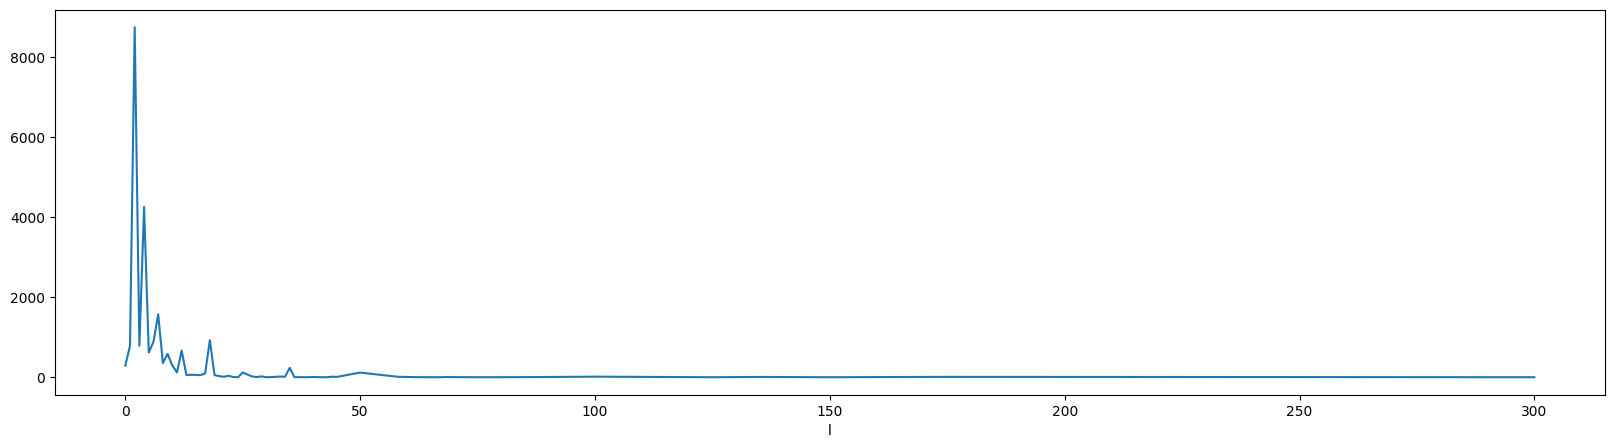

In [9]:
# Quick Viz of level progress rate
_u = user_progression_rate.copy()
_u['l'] = _u['levels_per_day'].round().astype(int)
_u.groupby('l')['user_id'].count().plot(kind='line', figsize=(20, 5)) #, xlim=(0, 20))

In [11]:
app_launches = actions_df[actions_df['event_name'] == 'App Launch'].copy()
user_launches = (
    app_launches
    .groupby('user_id')
    .size()
    .rename('launch_count')
    .reset_index()
)

user_launches.head()

,user_id,launch_count
0,00031c8da9dc1e05587b57b432770224384c230229944a...,2
1,0005b8adcae67d33e61d4570a53b30672e9e6d9773def3...,12
2,0007e015d8ad232584c680972af680e0831b781d095b04...,188
3,000c22eb20e5a2eeb96f4c2078fe938315cb26a178eda3...,6
4,000cdaa4c4e1ee501e803f68a5fedcefc205e28616f78f...,13


In [12]:
actions_by_date = (
    actions_df
    .groupby(['user_id', actions_df['action_datetime'].dt.date])
    .size()
    .rename('actions')
    .reset_index()
    .rename(columns={'action_datetime': 'date'})
)
actions_by_date.head()

days_active = (
    actions_by_date
    .groupby('user_id')
    .size()
    .rename('days_active')
    .reset_index()
)

days_active.head()

,user_id,days_active
0,00031c8da9dc1e05587b57b432770224384c230229944a...,2
1,0005b8adcae67d33e61d4570a53b30672e9e6d9773def3...,5
2,0007e015d8ad232584c680972af680e0831b781d095b04...,34
3,000c22eb20e5a2eeb96f4c2078fe938315cb26a178eda3...,6
4,000cdaa4c4e1ee501e803f68a5fedcefc205e28616f78f...,4


In [13]:
last_action_date = (
    actions_df
    .groupby('user_id')
    .agg(last_action=('action_datetime', 'max'))
    .reset_index()
)

last_action_date.head()


,user_id,last_action
0,00031c8da9dc1e05587b57b432770224384c230229944a...,2000-06-24 17:10:41
1,0005b8adcae67d33e61d4570a53b30672e9e6d9773def3...,2000-06-27 23:33:24
2,0007e015d8ad232584c680972af680e0831b781d095b04...,2000-06-30 20:50:12
3,000c22eb20e5a2eeb96f4c2078fe938315cb26a178eda3...,2000-05-09 06:25:00
4,000cdaa4c4e1ee501e803f68a5fedcefc205e28616f78f...,2000-05-04 17:24:23


In [14]:
user_features = user_installs[['user_id']]
user_features = pd.merge(user_features, user_max_level, on='user_id', how='left')
user_features = pd.merge(user_features, user_progression_rate, on='user_id', how='left')
user_features = pd.merge(user_features, user_launches, on='user_id', how='left')
user_features = pd.merge(user_features, days_active, on='user_id', how='left')
user_features = pd.merge(user_features, user_installs, on='user_id', how='left')
user_features = pd.merge(user_features, last_action_date, on='user_id', how='left')

user_features['max_level'] = user_features['max_level'].fillna(0)
user_features['levels_per_day'] = user_features['levels_per_day'].fillna(0)
user_features['launch_count'] = user_features['launch_count'].fillna(0)
user_features['days_active'] = user_features['days_active'].fillna(0)

user_features['days_since_install'] = (user_features['last_action'] - user_features['install_time']).dt.days
user_features['engagement_ratio'] = user_features['days_active'] / np.maximum(1, user_features['days_since_install'])
# user_features['engagement_ratio'] = user_features['launch_count'] / np.maximum(1, user_features['days_since_install'])

weekday_actions = actions_df[actions_df['action_datetime'].dt.dayofweek < 5].copy()
weekend_actions = actions_df[actions_df['action_datetime'].dt.dayofweek >= 5].copy()

weekday_counts = (
    weekday_actions
    .groupby('user_id')
    .size()
    .rename('weekday_actions')
    .reset_index()
)

weekend_counts = (
    weekend_actions
    .groupby('user_id')
    .size()
    .rename('weekend_actions')
    .reset_index()
)

user_features = pd.merge(user_features, weekday_counts, on='user_id', how='left')
user_features = pd.merge(user_features, weekend_counts, on='user_id', how='left')

user_features['weekday_actions'] = user_features['weekday_actions'].fillna(0)
user_features['weekend_actions'] = user_features['weekend_actions'].fillna(0)

user_features['total_actions'] = user_features['weekday_actions'] + user_features['weekend_actions']
user_features['weekend_ratio'] = np.where(user_features['total_actions'] > 0, user_features['weekend_actions'] / user_features['total_actions'], 0)
user_features.head()

,user_id,max_level,levels_per_day,launch_count,days_active,install_time,last_action,days_since_install,engagement_ratio,weekday_actions,weekend_actions,total_actions,weekend_ratio
0,00031c8da9dc1e05587b57b432770224384c230229944a...,7.0,7.000000,2.0,2,2000-06-23 19:14:11,2000-06-24 17:10:41,0,2.000000,4.0,2.0,6.0,0.333333
1,0005b8adcae67d33e61d4570a53b30672e9e6d9773def3...,12.0,12.000000,12.0,5,2000-06-23 15:47:35,2000-06-27 23:33:24,4,1.250000,10.0,9.0,19.0,0.473684
2,0007e015d8ad232584c680972af680e0831b781d095b04...,100.0,3.333333,188.0,34,2000-05-28 02:18:23,2000-06-30 20:50:12,33,1.030303,140.0,58.0,198.0,0.292929
3,000c22eb20e5a2eeb96f4c2078fe938315cb26a178eda3...,4.0,0.500000,6.0,6,2000-04-06 21:06:39,2000-05-09 06:25:00,32,0.187500,5.0,4.0,9.0,0.444444
4,000cdaa4c4e1ee501e803f68a5fedcefc205e28616f78f...,7.0,7.000000,13.0,4,2000-05-01 21:40:13,2000-05-04 17:24:23,2,2.000000,17.0,0.0,17.0,0.000000


### Building out the probabilities

In this section, I'm building a model to calculate the probability of users reaching specific level milestones within given time frames. This will help estimate the expected reward value for each user.

For each reward level defined in the rewards_df dataframe, I:
- Identify users who reached the target level and calculate how many days it took them
- Determine if they reached it within the time limit (these users get probability 1.0)
- For users who reached the level but after the time limit, assign probability 0.0
- For users who haven't reached the target level yet, I estimate their probability by:
   - Using their current progression rate
   - Considering how far they've already progressed
   - Calculating whether they're likely to reach the target within the remaining time

This approach allows me to estimate expected rewards even for users who haven't yet completed all milestones, providing a more complete picture of potential user value.


In [15]:
reward_probs = user_features[['user_id']].copy()

for _, reward in rewards_df.iterrows():
    if reward['level_name'] == 'Install':
        continue
        
    target_level = reward['level']
    time_limit = reward['days']
    reward_value = reward['user_reward']
    reward_key = f"p_{target_level}_in_{time_limit}"
    
    print(f"Processing {reward_key}: target_level={target_level}, time_limit={time_limit}, reward_value={reward_value}")
    
    # Get information about users who reached the target level
    reached_level = (
        level_progression[level_progression['level'] >= target_level]
        .groupby('user_id')
        .agg(days_to_reach_level=('days_since_install', 'min'))
        .reset_index()
    )
    
    print(f"Users who reached level {target_level}: {reached_level.shape[0]}")
    
    # Add the days_to_reach_level information to user_features for this calculation
    temp_features = pd.merge(
        user_features, 
        reached_level,
        on='user_id',
        how='left'
    )
    
    # fill in those that didn't reach the target
    temp_features['reached_target'] = ~temp_features['days_to_reach_level'].isna()
    # For those who didn't reach the target, use their current days_since_install
    temp_features['days_to_reach_level'] = temp_features['days_to_reach_level'].fillna(temp_features['days_since_install'])
    
    # Calculate probabilities
    temp_features[reward_key] = np.where(
        # Case 1: Reached level within time limit
        (temp_features['max_level'] >= target_level) & (temp_features['days_to_reach_level'] <= time_limit),
        1.0,
        np.where(
            # Case 2: Reached level but after time limit
            (temp_features['max_level'] >= target_level) & (temp_features['days_to_reach_level'] > time_limit),
            0.0,
            # Case 3: Haven't reached level yet - estimate probability
            np.minimum(1.0, 
                      temp_features['levels_per_day'] * np.maximum(0, time_limit - temp_features['days_to_reach_level']) / # Levels per day * time left
                      np.maximum(1, target_level - temp_features['max_level'])) # Levels to go
        )
    )
    
    # Transfer the calculated probability back to user_features
    user_features[reward_key] = temp_features[reward_key]
    user_features[f"exp_{target_level}_{time_limit}"] = user_features[reward_key] * reward_value
    
    print(f"Completed processing {reward_key}")

Processing p_35_in_10: target_level=35, time_limit=10, reward_value=10
Users who reached level 35: 6301
Completed processing p_35_in_10
Processing p_100_in_20: target_level=100, time_limit=20, reward_value=20
Users who reached level 100: 2663
Completed processing p_100_in_20
Processing p_175_in_50: target_level=175, time_limit=50, reward_value=40
Users who reached level 175: 1349
Completed processing p_175_in_50


In [16]:
# Sum all expected rewards
expected_value_columns = [col for col in user_features.columns if col.startswith('exp_')]
user_features['total_expected_reward'] = user_features[expected_value_columns].sum(axis=1)

#### Final Thoughts

Since we're dealing with a time-based reward system, we're seeing newer users appear more valuable 
simply because they have more future potential, while older users look less valuable because they've 
already "failed" to earn certain rewards.
Assuming this is the universe of users we have, taking a mean would help us get a more likely payout number.

In [122]:

mean_reward = user_features['total_expected_reward'].mean()
std_error = user_features['total_expected_reward'].std() / np.sqrt(len(user_features))
z_score = 1.96  # 95% confidence
lower_bound = mean_reward - z_score * std_error
upper_bound = mean_reward + z_score * std_error
print(f"Mean: {mean_reward:.2f} [{lower_bound:.2f}, {upper_bound:.2f}]")

Mean: 37.87 [37.56, 38.18]


In [18]:
# Calculate monthly expected rewards
user_features['install_month'] = user_features['install_time'].dt.to_period('M')

# Group by month and calculate statistics
monthly_rewards = user_features.groupby('install_month')['total_expected_reward'].agg(['mean', 'std', 'count']).reset_index()

# Calculate confidence intervals (95%)
z_score = 1.96
monthly_rewards['std_error'] = monthly_rewards['std'] / np.sqrt(monthly_rewards['count'])
monthly_rewards['lower_bound'] = monthly_rewards['mean'] - z_score * monthly_rewards['std_error']
monthly_rewards['upper_bound'] = monthly_rewards['mean'] + z_score * monthly_rewards['std_error']

# Display the results
print("Monthly Expected Rewards with 95% Confidence Intervals:")
for _, row in monthly_rewards.iterrows():
    print(f"{row['install_month']}: {row['mean']:.2f} [{row['lower_bound']:.2f}, {row['upper_bound']:.2f}] (n={row['count']})")



Monthly Expected Rewards with 95% Confidence Intervals:
2000-04: 34.14 [33.62, 34.66] (n=9693)
2000-05: 37.14 [36.49, 37.79] (n=6146)
2000-06: 41.31 [40.85, 41.78] (n=11788)


         month  mean_reward  lower_bound  upper_bound  sample_size
0   2000-04-01    30.658750    27.938087    33.379413          317
1   2000-04-02    28.887940    26.171464    31.604416          309
2   2000-04-03    32.049937    28.629839    35.470036          240
3   2000-04-04    36.023797    32.965089    39.082506          266
4   2000-04-05    34.723135    31.666699    37.779571          257
..         ...          ...          ...          ...          ...
86  2000-06-26    45.829142    42.644709    49.013576          277
87  2000-06-27    45.431679    42.030731    48.832628          220
88  2000-06-28    45.521340    41.185669    49.857010          146
89  2000-06-29    43.393923    39.386692    47.401153          167
90  2000-06-30    46.790671    41.646077    51.935264           89

[91 rows x 5 columns]


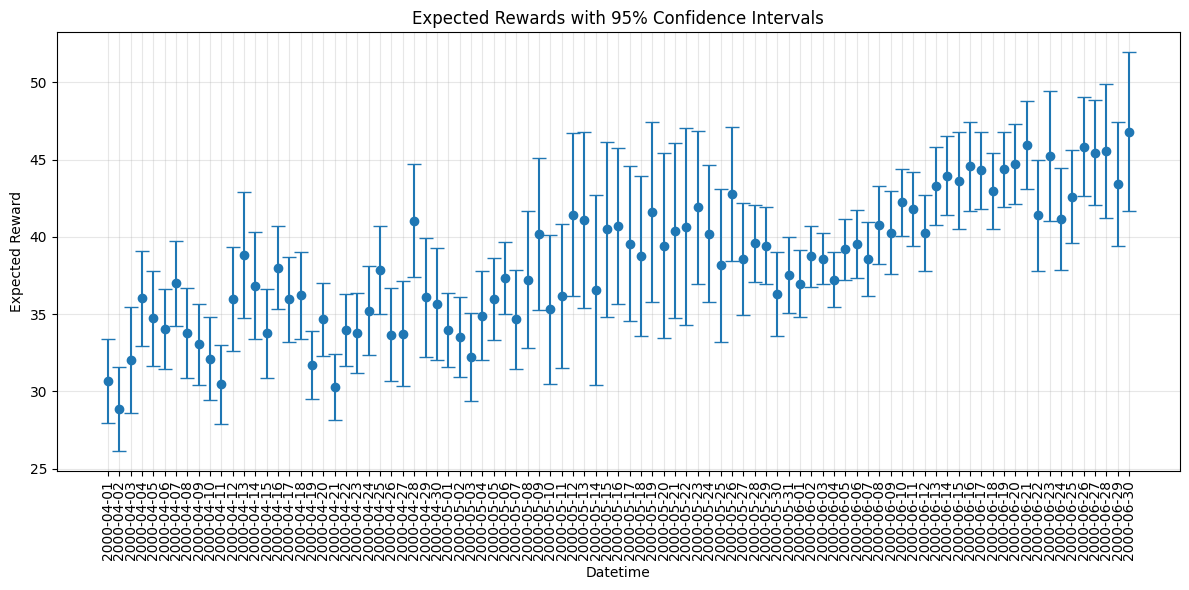


Thoughts: Since we're dealing with a time-based reward system, we're seeing newer users appear more valuable 
simply because they have more future potential, while older users look less valuable because they've 
already "failed" to earn certain rewards.



In [18]:
user_features['install_month'] = user_features['install_time'].dt.to_period('D')

# Group by month and calculate statistics for each month
monthly_stats = []

for month, group in user_features.groupby('install_month'):
    mean_reward = group['total_expected_reward'].mean()
    std_error = group['total_expected_reward'].std() / np.sqrt(len(group))
    
    # For 95% confidence interval
    z_score = 1.96 
    lower_bound = mean_reward - z_score * std_error
    upper_bound = mean_reward + z_score * std_error
    
    # Store the results
    monthly_stats.append({
        'month': month,
        'mean_reward': mean_reward,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'sample_size': len(group)
    })

# Convert to DataFrame for easy viewing/plotting
monthly_stats_df = pd.DataFrame(monthly_stats)

plt.figure(figsize=(12, 6))
plt.errorbar(
    x=monthly_stats_df['month'].astype(str),
    y=monthly_stats_df['mean_reward'],
    yerr=[(monthly_stats_df['mean_reward'] - monthly_stats_df['lower_bound']), 
          (monthly_stats_df['upper_bound'] - monthly_stats_df['mean_reward'])],
    fmt='o',
    capsize=5
)
plt.title('Expected Rewards with 95% Confidence Intervals')
plt.xlabel('Datetime')
plt.ylabel('Expected Reward')
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## In App Purchases

Thoughts: I'm considering splitting the objective into two parts:
- Build a prediction model for purchase probability (binary classification)
- Build a regression model for purchase value (for users who make a purchase)

This two-stage approach allows us to first predict whether a user will make a purchase, and then estimate how much they'll spend if they do. The expected value would be: P(purchase) * E(purchase_value | purchase).


### Create feature set for purchases at the offer_start_id level

In [19]:
offer_dates = (
    actions_df[actions_df['action_type'] == 'install']
    .groupby('offer_start_id')
    .agg(
        install_date=('action_datetime', 'min'),
    )
    .reset_index()
)

offer_actions = pd.merge(actions_df, offer_dates, on=['offer_start_id'], how='left')
offer_actions['days_since_install'] = (offer_actions['action_datetime'] - offer_actions['install_date']).dt.days
offer_actions = offer_actions[offer_actions['days_since_install'] <= 50].copy()
offer_actions['level_number'] = offer_actions['event_name'].str.extract(r'Reach Level (\d+)').fillna(0).astype(int)

# Remove data for offers that didn't have 50 days to mature
offer_actions = offer_actions[offer_actions['install_date'] <= (offer_actions['action_datetime'].max() - pd.Timedelta(days=50))].copy()

In [20]:
offer_purchase_state = (
    offer_actions.groupby('offer_start_id').agg(
        has_purchase=('action_type', lambda x: (x == 'purchase').any()),
        purchase_count=('action_type', lambda x: (x == 'purchase').sum()),
        purchase_total=('action_value', lambda x: x[actions_df.loc[x.index, 'action_type'] == 'purchase'].sum()),
        install_date=('install_date', 'max'),
        last_action_date=('action_datetime', 'max'),
        reinstalled=('action_type', lambda x: (x == 'install').sum()>1),
        reinstall_count=('action_type', lambda x: (x == 'install').sum()),
        made_progress=('action_type', lambda x: (x == 'progress').any()),
        progress_count=('action_type', lambda x: (x == 'progress').sum()),
        max_level=('level_number', 'max')
    )
    .reset_index()
)

In [21]:
offer_purchase_state['active_days'] = (offer_purchase_state['last_action_date'] - offer_purchase_state['install_date']).dt.days + 1
offer_purchase_state['level_per_day'] = offer_purchase_state['max_level'] / offer_purchase_state['active_days']

### Model Building

1. Handling Class Imbalance with SMOTE
Our dataset shows significant imbalance between purchasers (minority) and non-purchasers (majority).
Synthetic Minority Over-sampling Technique (SMOTE) will be used to create synthetic examples
of the minority class, helping the model learn more balanced decision boundaries.

2. Model Selection via GridSearch
We'll evaluate multiple classification algorithms (Naive Bayes variants, Random Forest, XGBoost)
using GridSearchCV to systematically work through specified parameter values for each model.
This helps identify the best-performing model and optimal hyperparameters simultaneously.

3. Evaluation Strategy
Models will be evaluated using:
  - ROC-AUC: Measures discrimination ability across thresholds (robust to imbalance)
  - Precision-Recall metrics: Important for business context where false positives/negatives have different costs
  - Cross-validation: To ensure model stability and generalizability

4. Final Model Selection
The best model will be selected based on performance metrics and business requirements,
with consideration for both predictive power and interpretability.

In [81]:
feature_cols = [
    'reinstall_count', 
    'max_level', 
    'active_days', 
    'level_per_day'
]

# 2. Stage 1: Purchase Probability Model
X = offer_purchase_state[feature_cols]
y_binary = offer_purchase_state['has_purchase'].astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Original class distribution:")
print(f"No purchase: {(y_train == 0).sum()} ({(y_train == 0).mean():.2%})")
print(f"With purchase: {(y_train == 1).sum()} ({(y_train == 1).mean():.2%})")

# Apply SMOTE to try to balance the purchased data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

X_train_smote, y_train_smote = X_train, y_train

print(f"After SMOTE resampling:")
print(f"No purchase: {(y_train_smote == 0).sum()} ({(y_train_smote == 0).mean():.2%})")
print(f"With purchase: {(y_train_smote == 1).sum()} ({(y_train_smote == 1).mean():.2%})")

Original class distribution:
No purchase: 8886 (85.33%)
With purchase: 1528 (14.67%)
After SMOTE resampling:
No purchase: 8886 (50.00%)
With purchase: 8886 (50.00%)


There's not a lot of data, so I'm using Gridsearch to quickly run through various parameters to see which model would work best.
The models used and their reasons for being used are:

- GaussianNB - Simple probabilistic classifier based on Bayes' theorem. Works well with small datasets and provides probability estimates naturally.
- BernoulliNB - Variant of Naive Bayes suited for binary/boolean features. May work well for our purchase prediction task which is a binary classification problem.
- RandomForest - Robust to overfitting and handles imbalanced data well. It can capture non-linear relationships and feature interactions.
- XGBoost - Gradient boosting algorithm that often achieves state-of-the-art results. It has built-in regularization and handles imbalanced data with scale_pos_weight parameter.
 
Note: Considered NaiveBayes first in hopes of better explanability.

In [76]:

# Gridsearch for the best model

# Define f2 score using fbeta to use for the gridsearch
f2_score = make_scorer(fbeta_score, beta=0, pos_label=1)

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'max_samples': [0.5, 0.7, 0.9, None],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'scale_pos_weight': [1, 3, 5] 
}

nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

bernoulli_nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'binarize': [0.0, 0.3, 0.5]
}

# Create a dictionary of models to evaluate
models = {
    'RandomForest': (RandomForestClassifier(random_state=42), rf_param_grid),
    'XGBoost': (XGBClassifier(random_state=42), xgb_param_grid),
    'GaussianNB': (GaussianNB(), nb_param_grid),
    'BernoulliNB': (BernoulliNB(), bernoulli_nb_param_grid)
}

# Dictionary to store best models
best_models = {}
best_scores = {}

# Evaluate each model with its parameter grid
for model_name, (model, param_grid) in models.items():
    print(f"\nEvaluating {model_name}...")
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring=f2_score,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit GridSearchCV
    grid_search.fit(X_train_smote, y_train_smote)
    
    # Store results
    best_models[model_name] = grid_search.best_estimator_
    best_scores[model_name] = grid_search.best_score_
    
    # Print results for this model
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best F1 score for {model_name}: {grid_search.best_score_:.4f}")

# Find the overall best model
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]

print("\n===== Overall Best Model =====")
print(f"Best model: {best_model_name}")
print(f"Best F1 score: {best_scores[best_model_name]:.4f}")
print(f"Model details: {best_model}")


Evaluating RandomForest...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters for RandomForest: {'class_weight': 'balanced', 'max_features': None, 'max_samples': None, 'min_samples_leaf': 2, 'n_estimators': 200}
Best F1 score for RandomForest: 0.8956

Evaluating XGBoost...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.8}
Best F1 score for XGBoost: 0.8913

Evaluating GaussianNB...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for GaussianNB: {'var_smoothing': 1e-09}
Best F1 score for GaussianNB: 0.8954

Evaluating BernoulliNB...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for BernoulliNB: {'alpha': 0.1, 'binarize': 0.5}
Best F1 score for BernoulliNB: 0.6006

===== Overall Best Model =====
Best model: RandomForest
Best F1 score: 0

### Model Performance Analysis

The precision and recall for the purchased class is quite poor. This is not surprising given the limited amount of data available for training. 
To improve the model performance, several approaches could be considered:

- Data Augmentation: Collect more user-specific attributes that might be predictive of purchasing behavior
- Hyperparameter Tuning: Further optimize the model parameters. There may have been more tuning I could've done that I could later inspect its performance.

The current results suggest that we need more discriminative features to better identify potential purchasers from non-purchasers.

In [119]:
prob_model = RandomForestClassifier(
    class_weight='balanced', 
    min_samples_leaf=2,
    n_estimators=200,
    random_state=42
)

prob_model.fit(X_train_smote, y_train_smote)
y_prob = prob_model.predict_proba(X_test)[:, 1]
y_pred = prob_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      2222
           1       0.49      0.66      0.56       382

    accuracy                           0.85      2604
   macro avg       0.71      0.77      0.74      2604
weighted avg       0.87      0.85      0.86      2604



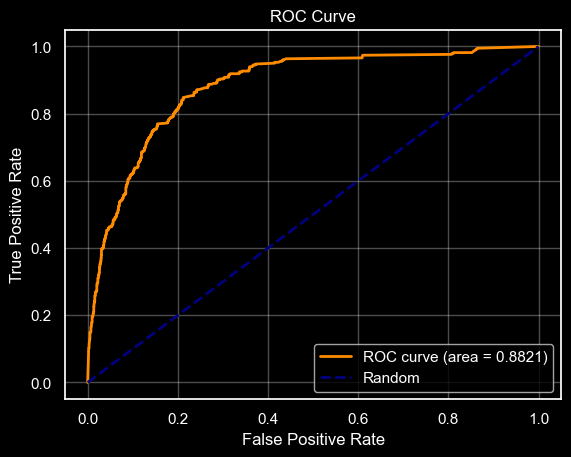

In [112]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

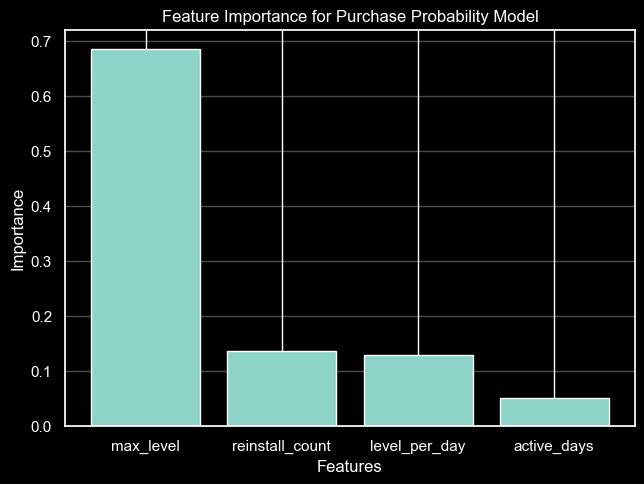

In [115]:
importances = prob_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

plt.title('Feature Importance for Purchase Probability Model')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices])
plt.tight_layout()
plt.ylabel('Importance')
plt.xlabel('Features')
plt.grid(axis='y', alpha=0.3)

### Purchase Amount Prediction Model

In this section, we'll build a regression model to predict the purchase amount for users who make a purchase. This complements our previous classification model that predicts the probability of purchase.

In [92]:
purchasers = offer_purchase_state[offer_purchase_state['has_purchase'] == 1]
X_amt = purchasers[feature_cols]
y_amt = purchasers['purchase_total']

# Train amount model
amt_model = RandomForestRegressor(n_estimators=100, random_state=42)
amt_model.fit(X_amt, y_amt)

# Evaluate purchase amount model
preds = amt_model.predict(X_amt)
mae = mean_absolute_error(y_amt, preds)
avg_purchase = y_amt.mean()

print(f"Purchase amount model - MAE: {mae:.2f}")
print(f"Average purchase amount: ${avg_purchase:.2f}")

Purchase amount model - MAE: 14.56
Average purchase amount: $49.77


### Predicting in-game purchase together

Now we'll combine our two models to predict the expected value of in-game purchases for new users.

The approach is:
1. Use the probability model to predict the likelihood of a user making a purchase
2. Use the amount model to predict how much they would spend if they do purchase
3. Multiply these values to get the expected value of purchases per user

We also calculate confidence intervals to understand the uncertainty in our predictions.



In [105]:
# Calculate median features for recent offers
july_features = (
    offer_purchase_state[feature_cols]
    .median()
)

# Make predictions
july_purchase_prob = prob_model.predict_proba(pd.DataFrame([july_features]))[0, 1]
july_purchase_amount = amt_model.predict(pd.DataFrame([july_features]))[0]

# Calculate expected value
expected_purchase_value = july_purchase_prob * july_purchase_amount

# Calculate upper and lower bounds (using 95% confidence interval)


# For purchase probability
n_estimators = len(prob_model.estimators_)
prob_predictions = np.array([tree.predict_proba(pd.DataFrame([july_features]))[0, 1] 
                            for tree in prob_model.estimators_])
prob_lower, prob_upper = stats.norm.interval(0.95, 
                                            loc=prob_predictions.mean(), 
                                            scale=prob_predictions.std() / np.sqrt(n_estimators))

# For purchase amount
amount_predictions = np.array([tree.predict(pd.DataFrame([july_features]))[0] 
                              for tree in amt_model.estimators_])
amount_lower, amount_upper = stats.norm.interval(0.95, 
                                               loc=amount_predictions.mean(), 
                                               scale=amount_predictions.std() / np.sqrt(n_estimators))


# Expected value bounds
ev_lower = prob_lower * amount_lower
ev_upper = prob_upper * amount_upper

print("\nPrediction for July 1st offers:")
print(f"Probability of purchase within 50 days: {july_purchase_prob:.4f} (95% CI: {prob_lower:.4f}-{prob_upper:.4f})")
print(f"Expected purchase amount (if purchase occurs): ${july_purchase_amount:.2f} (95% CI: ${amount_lower:.2f}-${amount_upper:.2f})")
print(f"Expected in-game purchases per offer install: ${expected_purchase_value:.2f} (95% CI: ${ev_lower:.2f}-${ev_upper:.2f})")


Prediction for July 1st offers:
Probability of purchase within 50 days: 0.0887 (95% CI: 0.0764-0.1011)
Expected purchase amount (if purchase occurs): $11.01 (95% CI: $10.21-$11.81)
Expected in-game purchases per offer install: $0.98 (95% CI: $0.78-$1.19)


## Suggested Adjustments to the Reward Structure for Better User Retention

Our analysis reveals several concerning patterns:
1. The offer completion rate is significantly low
2. There's a sharp decline in user retention after the first week
3. The current reward structure doesn't align with game difficulty progression

### Possible Hypotheses for Low Completion and High Churn:
- Game difficulty increases causing players to abandon
- Reward milestones appear unattainable, discouraging continued play
- The effort-to-reward ratio becomes increasingly unfavorable
- Players experience burnout due to the sustained high level requirements

### Proposed Structural Changes:

1. Progressive Difficulty Adjustment
- Align reward timeframes with the natural difficulty curve of the game
- Decrease the levels-per-day requirement as players progress to higher levels
- Current data shows Level 100 requires 5 levels/day while Level 175 requires 3.5 levels/day, but the latter offers less reward_per_level than reaching level 0 to 35

2. Balanced Effort-to-Reward Ratio
- Maintain or increase the reward-per-level as difficulty increases
- From our data, the reward-per-level decreases from 0.29 for Level 35 to 0.20 for Level 100, then slightly increases to 0.23 for Level 175
- This declining reward ratio likely contributes to player disengagement

3. Micro-Rewards and Engagement Hooks
- Implement smaller, more frequent rewards between major milestones to maintain interest
- Create a "streak" bonus system to encourage daily/weekly play
- Consider weekly mini-goals that align with the observed weekly engagement cycle

4. Early Retention Focus
- Front-load more attainable rewards in the first 7-10 days to combat the week-one drop-off
- Create incentives to push users through the initial difficulty curve

By restructuring rewards to better match player progression patterns and psychological motivators, we can likely improve both completion rates and overall retention, ultimately increasing the ROI for both Almeida and the game developer.

In [146]:
rewards_df['levels_per_day'] = rewards_df['level'] / rewards_df['days']
rewards_df['reward_per_level'] = rewards_df['user_reward'] / rewards_df['level']
rewards_df['reward_per_day'] = rewards_df['user_reward'] / rewards_df['days']
rewards_df = rewards_df.sort_values(by='level', ascending=True)
# Create a new column with the previous level
rewards_df['prev_level'] = rewards_df['level'].shift(1)
rewards_df['prev_days'] = rewards_df['days'].shift(1)
rewards_df['level_diff'] = rewards_df['level'] - rewards_df['prev_level']
rewards_df['days_diff'] = rewards_df['days'] - rewards_df['prev_days']


rewards_df.head()

,level_name,level,revenue,user_reward,days,levels_per_day,reward_per_level,reward_per_day,prev_level,prev_days,level_diff,days_diff
0,Install,0,10,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Reach Level 35,35,0,10,10,3.5,0.285714,1.0,0.0,0.0,35.0,10.0
2,Reach Level 100,100,0,20,20,5.0,0.200000,1.0,35.0,10.0,65.0,10.0
3,Reach Level 175,175,0,40,50,3.5,0.228571,0.8,100.0,20.0,75.0,30.0


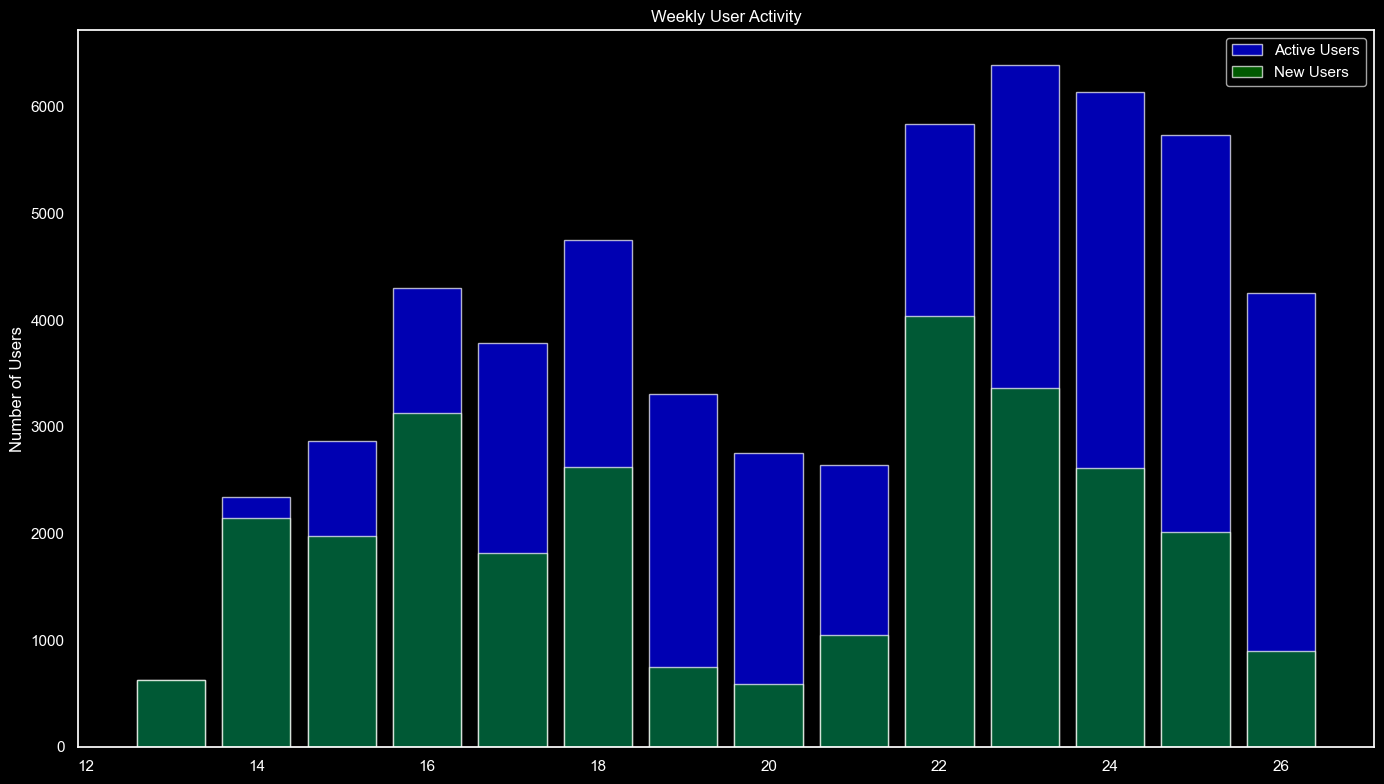

In [133]:
# First, convert action_datetime to datetime if it's not already
actions_df['action_datetime'] = pd.to_datetime(actions_df['action_datetime'])

# Extract week information
actions_df['week'] = actions_df['action_datetime'].dt.isocalendar().week

# Count unique users per week
weekly_active_users = actions_df.groupby('week')['user_id'].nunique().reset_index()
weekly_active_users.columns = ['week', 'active_users']

# Calculate new users each week (first appearance)
user_first_week = actions_df.groupby('user_id')['week'].min().reset_index()
new_users_per_week = user_first_week.groupby('week').size().reset_index()
new_users_per_week.columns = ['week', 'new_users']

# Calculate churned users (users who don't appear in the following week)
all_weeks = sorted(actions_df['week'].unique())
churned_users = []

for i in range(len(all_weeks) - 1):
    current_week = all_weeks[i]
    next_week = all_weeks[i + 1]
    
    # Users in current week
    current_users = set(actions_df[actions_df['week'] == current_week]['user_id'].unique())
    
    # Users in next week
    next_users = set(actions_df[actions_df['week'] == next_week]['user_id'].unique())
    
    # Users who churned (in current week but not in next week)
    churned = current_users - next_users
    
    churned_users.append({
        'week': current_week,
        'churned_users': len(churned)
    })

churned_users_df = pd.DataFrame(churned_users)

# Merge all dataframes
churn_analysis = weekly_active_users.merge(new_users_per_week, on='week', how='left')
churn_analysis = churn_analysis.merge(churned_users_df, on='week', how='left')
churn_analysis.fillna(0, inplace=True)

plt.figure(figsize=(14, 8))
plt.bar(churn_analysis['week'], churn_analysis['active_users'], color='blue', alpha=0.7, label='Active Users')
plt.bar(churn_analysis['week'], churn_analysis['new_users'], color='green', alpha=0.7, label='New Users')
plt.ylabel('Number of Users')
plt.title('Weekly User Activity')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


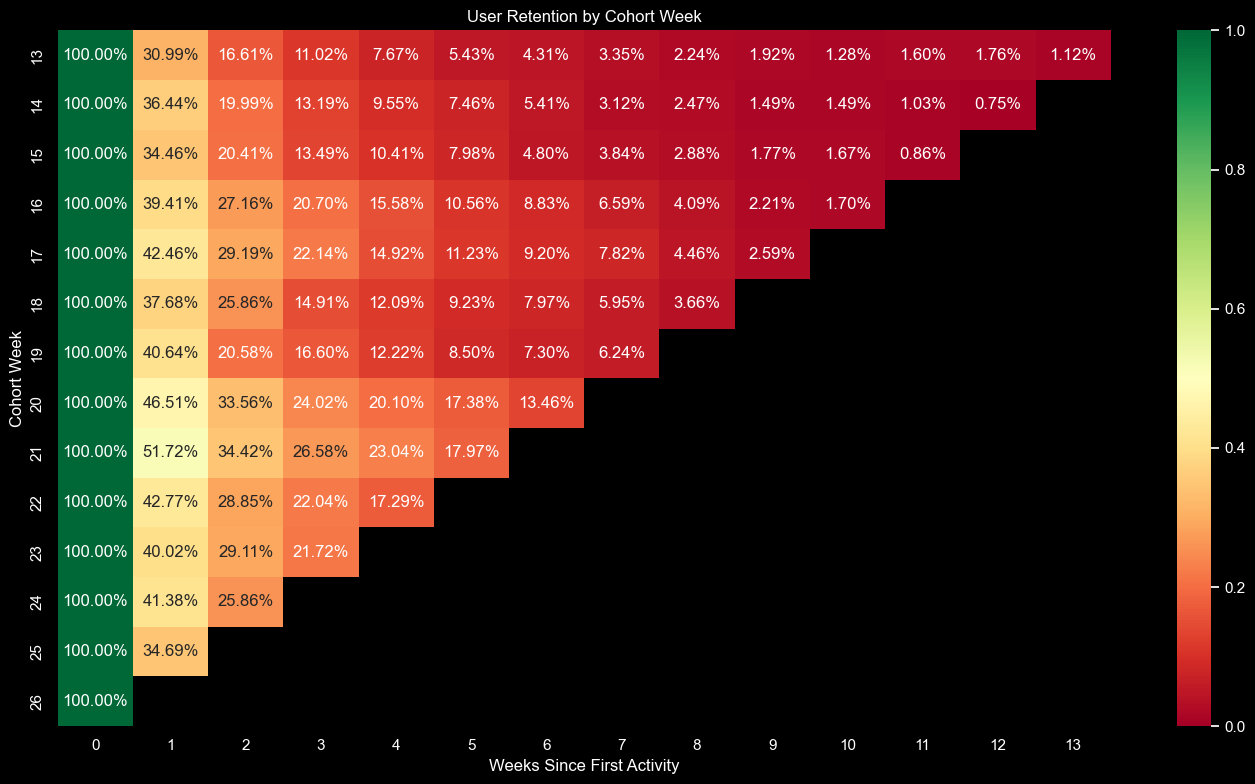

In [152]:

cohorts = user_first_week.copy()
cohorts.columns = ['user_id', 'cohort_week']

user_activity = actions_df[['user_id', 'week']].copy()
user_activity = user_activity.merge(cohorts, on='user_id', how='left')
user_activity['week_number'] = user_activity['week'] - user_activity['cohort_week']

retention_data = (
    user_activity.groupby(['cohort_week', 'week_number'])['user_id'].nunique()
    .reset_index()
    .rename(columns={'user_id': 'user_count'})
)

retention_pivot = retention_data.pivot(index='cohort_week', columns='week_number', values='user_count')

# Calculate retention rates
cohort_sizes = retention_pivot[0].copy()
retention_rates = retention_pivot.div(cohort_sizes, axis=0)

# Plot the retention triangle heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(retention_rates, annot=True, fmt='.2%', cmap='RdYlGn', vmin=0, vmax=1)
plt.title('User Retention by Cohort Week')
plt.xlabel('Weeks Since First Activity')
plt.ylabel('Cohort Week')
plt.grid(False)
plt.tight_layout()
plt.show()

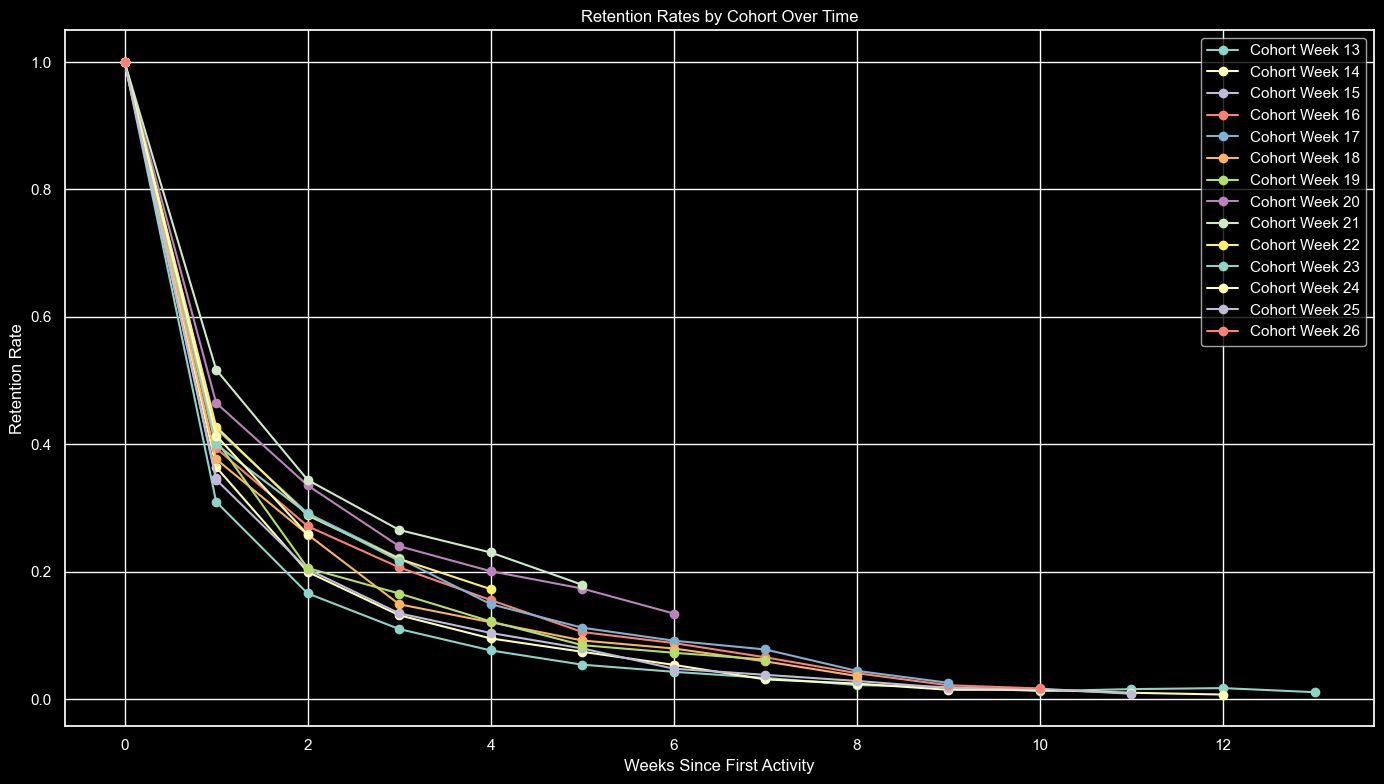

In [153]:
# Plot churn by weeks for each cohort
plt.figure(figsize=(14, 8))

# For each cohort, plot the retention rate over time
for cohort in retention_rates.index:
    
    # Get the retention data for this cohort
    cohort_data = retention_rates.loc[cohort]
    
    # Plot the retention curve
    plt.plot(cohort_data.index, cohort_data.values, marker='o', label=f'Cohort Week {cohort}')

plt.title('Retention Rates by Cohort Over Time')
plt.xlabel('Weeks Since First Activity')
plt.ylabel('Retention Rate')
plt.legend()
plt.tight_layout()
plt.show()